## MILP Approach for Small Instances

fixed cost first echelon vehicles - 100  
fixed cost second echelon vehicles - 50

In [1]:
import pandas as pd

data = pd.read_excel("Data\Instances\Small_Instances.xlsx", sheet_name='A1', index_col=0)
data = data[['X', 'Y']]

solution_variables = pd.read_excel('solution.xlsx', index_col=0)

In [2]:
data.head()

,X,Y
Number,,
1,47.416821,53.807242
2,13.439768,8.259892
3,35.115685,44.278523
4,17.539752,23.700627
5,37.094541,19.816419


In [3]:
solution_variables.head()

,value
"R_ij_t[1,3,1]",1.0
"R_ij_t[2,4,2]",1.0
"R_ij_t[3,5,1]",1.0
"R_ij_t[4,6,2]",1.0
"R_ij_t[5,1,1]",1.0


In [4]:
def route_plot(data, solution_variables):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 10))

    # plot depots [1, 2]
    plt.scatter(data['X'][1], data['Y'][1], color='blue', label='Depot', s=400)
    plt.scatter(data['X'][2], data['Y'][2], color='orange', label='Depot', s=400)

    # plot satellites [3, 4, 5, 6] (3, 5 belong to LSP 1, 4, 6 belong to LSP 2)
    plt.scatter(data['X'][3], data['Y'][3], color='blue', label='Satellite', s=400)
    plt.scatter(data['X'][4], data['Y'][4], color='orange', label='Satellite', s=400)
    plt.scatter(data['X'][5], data['Y'][5], color='blue', label='Satellite', s=400)
    plt.scatter(data['X'][6], data['Y'][6], color='orange', label='Satellite', s=400)

    # plot customers [7-18] (even numbers belong to LSP 1, odd numbers belong to LSP 2) (colour according to LSP)
    for i in range(7, 19):
        if i % 2 == 0:
            plt.scatter(data['X'][i], data['Y'][i], color='blue', label='Customer', s=400)
        else:
            plt.scatter(data['X'][i], data['Y'][i], color='orange', label='Customer', s=400)

    # plot collaboration points [19, 20]
    plt.scatter(data['X'][19], data['Y'][19], color='green', label='Collaboration Point', s=400)
    plt.scatter(data['X'][20], data['Y'][20], color='green', label='Collaboration Point', s=400)

    # plt.scatter(data['X'], data['Y'], color='blue')
    for i in data.index:
        plt.annotate(i, (data['X'][i], data['Y'][i]), color='black')


    # first-echelon
    for variable_name in solution_variables.index:
        if variable_name[0] == 'R':
            point_a = int(variable_name[7])
            point_b = int(variable_name[9])
            plt.arrow(data['X'][point_a], data['Y'][point_a], data['X'][point_b] - data['X'][point_a], data['Y'][point_b] - data['Y'][point_a], color='red',
            head_width=0.35)
            
    # second-echelon
    for variable_name in solution_variables.index:
        if variable_name[0] == 'X':
            point_a = int(variable_name.split(',')[0].split('[')[-1])
            point_b = int(variable_name.split(',')[1])
            plt.arrow(data['X'][point_a], data['Y'][point_a], data['X'][point_b] - data['X'][point_a], data['Y'][point_b] - data['Y'][point_a], color='purple',
            head_width=0.35)

## Proposed Approach (Collaboration Points)

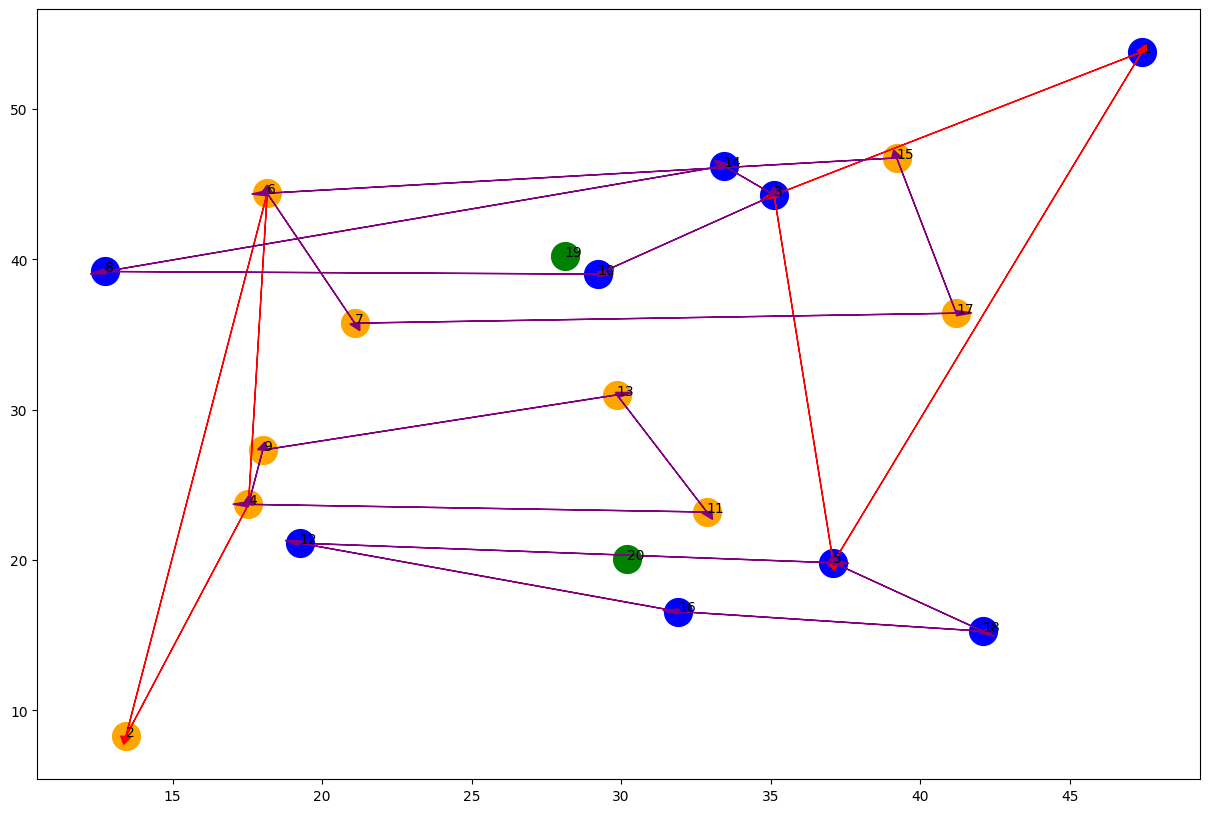

In [5]:
route_plot(data, solution_variables)

## No Collaboration Approach (Dellaert 19)

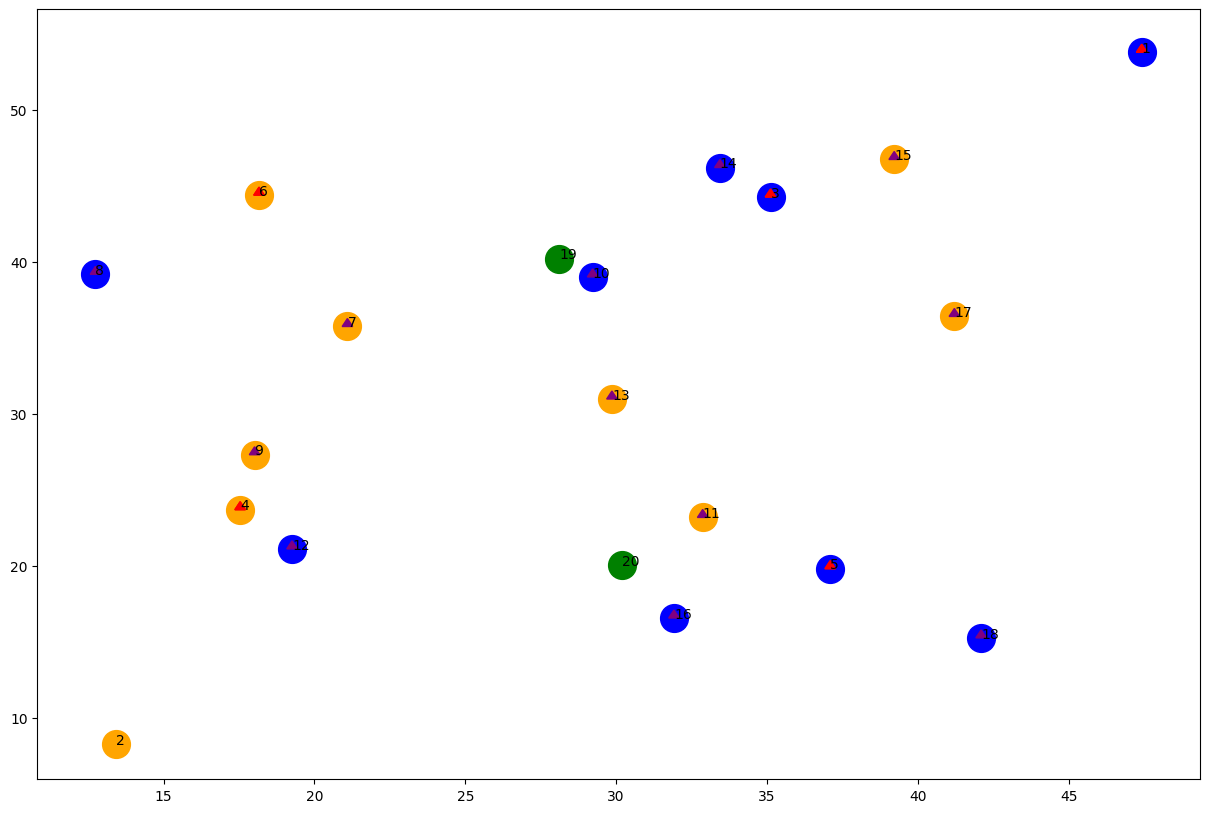

In [6]:
solution_variables_nc = pd.read_excel('solution_NC_d19.xlsx', index_col=0)

route_plot(data, solution_variables_nc)

## Asset Sharing Approach (Dellaert 21)

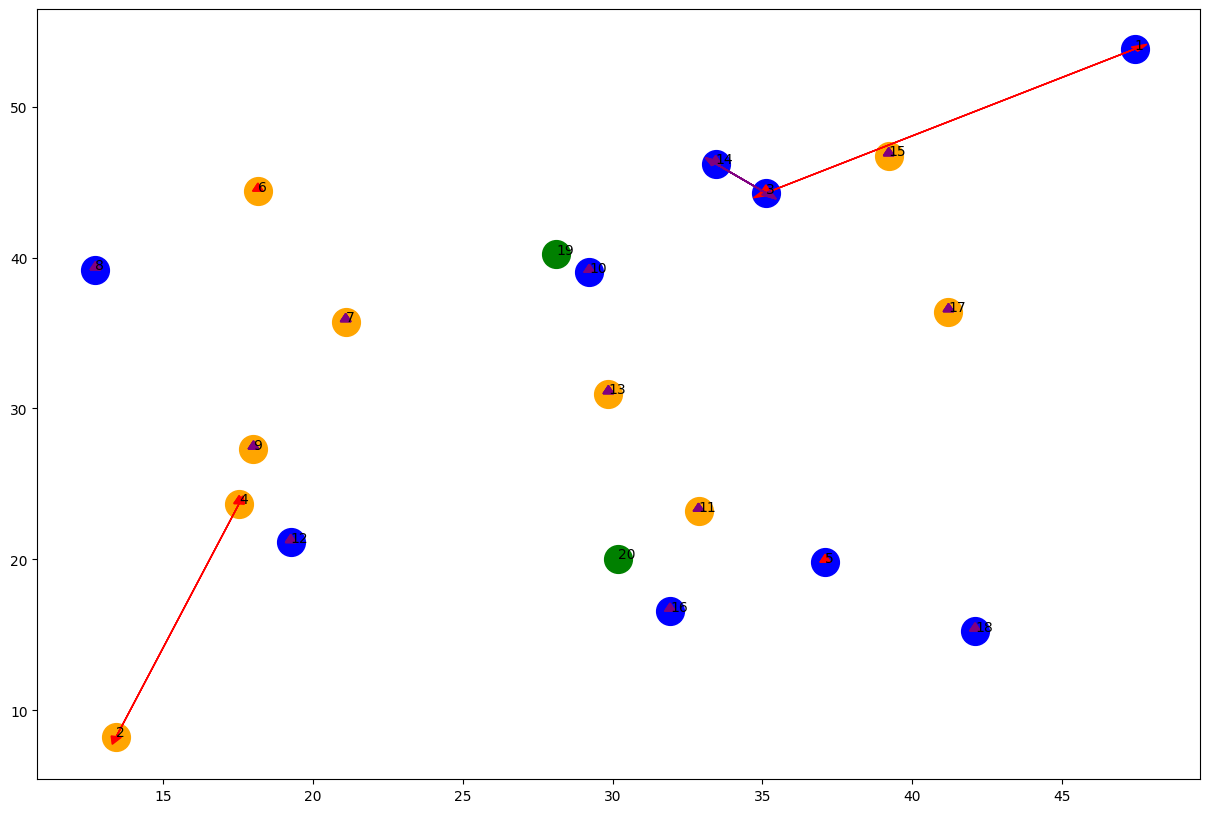

In [7]:
solution_variables_as = pd.read_excel('solution_SA_d21.xlsx', index_col=0)

route_plot(data, solution_variables_as)

## Proposed Approach (Collaboration Points)

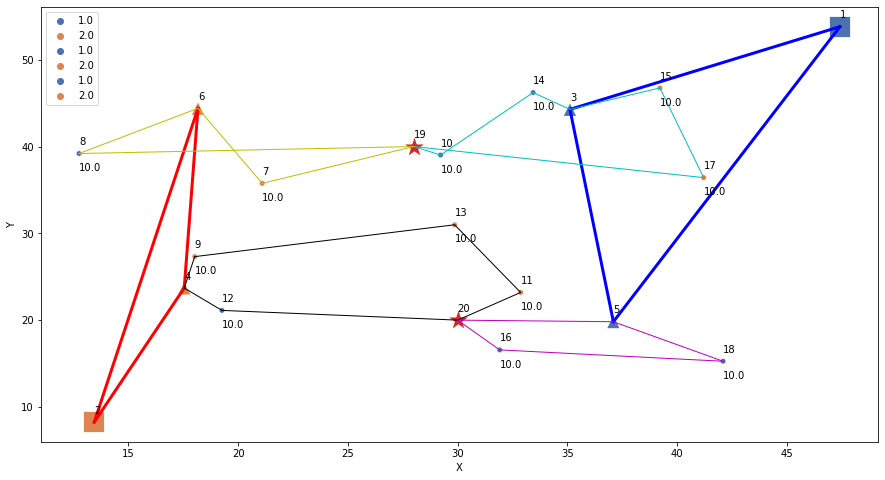

Satellite 3, LSP 1, Vehicle 6
Customers - 14 -> 10 -> 19 -> 17 -> 15 (original customer -> 8, exchanged customers -> 17, 15)

Satellite 6, LSP 2, Vehicle 3
Customers - 7 -> 19 -> 8 (original customer -> 17, 15, exchanged customers -> 8)


X_ij_v  
[3, 14, 6] = 1
[14, 10, 6] = 1
[10, 19, 6] = 1
[19, 17, 6] = 1
[17, 15, 6] = 1
[15, 3, 6] = 1


[6, 7, 3] = 1
[7, 19, 3] = 1
[19, 8, 3] = 1
[8, 6, 3] = 1


H_ij_v
[3, 14, 6] = 30
[14, 10, 6] = 20
[10, 19, 6] = 10
[19, 17, 6] = 20
[17, 15, 6] = 10
[15, 3, 6] = 0


[6, 7, 3] = 30
[7, 19, 3] = 20
[19, 8, 3] = 10
[8, 6, 3] = 0



Y_c_v
[14, 6] = 1
[10, 6] = 1
[19, 6] = 1
[17, 6] = 1
[15, 6] = 1 



[7, 3] = 1
[19, 3] = 1
[8, 3] = 1



Q_c_s
[14, 3] = 1
[10, 3] = 1
[19, 3] = 1
[17, 3] = 1
[15, 3] = 1
(or maybe it'll be [8, 3] = 1)


[7, 6] = 1
[19, 6] = 1
[8, 6] = 1
(or maybe it'll be [17, 6] = 1, [15, 6] = 1)